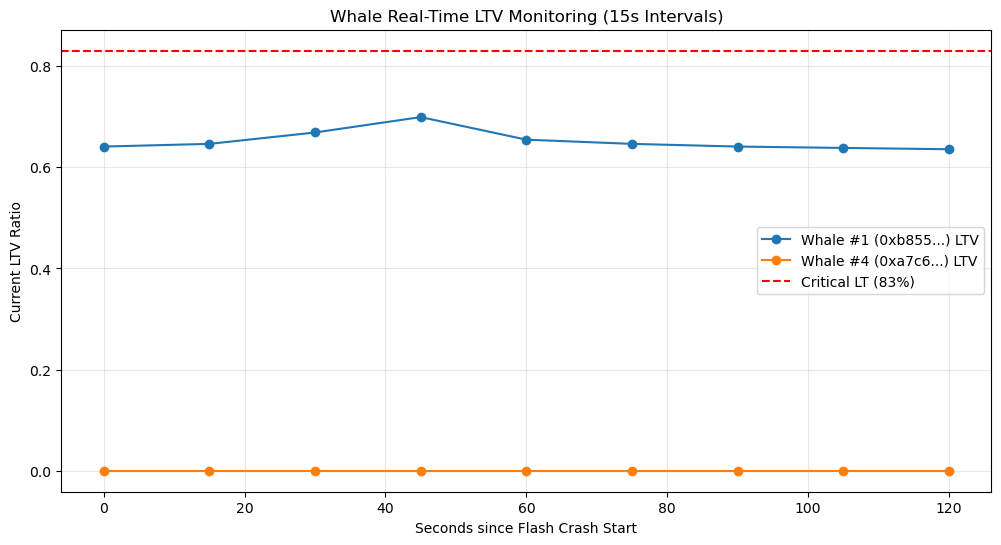

Whale     Whale #1 (0xb855...)  Whale #4 (0xa7c6...)
Time_Sec                                            
0                       0.6407                0.0004
15                      0.6460                0.0004
30                      0.6685                0.0004
45                      0.6989                0.0004
60                      0.6543                0.0004
75                      0.6460                0.0004
90                      0.6407                0.0004
105                     0.6380                0.0004
120                     0.6354                0.0004


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Audit Scope Initialization ---
# Liquidation Thresholds (LT) from Aave Smart Contracts (image_11970b.png)
LT_CONFIG = {
    'WETH': 0.825,   # 82.5%
    'weETH': 0.80,   # 80.0%
    'WBTC': 0.75,    # 75.0%
    'USDC': 0.75     # Stablecoin buffer
}

# Real data for the Top 5 Whales from your SQL (image_1122e4.jpg / image_e9215a.png)
# Units: Amounts are in absolute token units, Debt is in USD (USDT)
whales_data = {
    'Whale #1 (0xb855...)': {
        'debt_usd': 63000000,
        'collateral': {'WETH': 40974, 'USDC': 0}
    },
    'Whale #4 (0xa7c6...)': {
        'debt_usd': 3177674,
        'collateral': {'weETH': 2244948, 'WETH': 1320000, 'WBTC': 80.14}
    }
    # Add other whales from your SQL results here...
}

# --- 2. Mocking the Oracle Price Series (Replace with your CSV data) ---
# Professor wants 15-second intervals (approx. 1 block time)
# Here we simulate the flash crash movement reported by Chainlink
time_steps = range(0, 121, 15) # 0 to 120 seconds, every 15s
price_series = {
    'WETH':  [2400, 2380, 2300, 2200, 2350, 2380, 2400, 2410, 2420], # Sample Oracle drift
    'weETH': [2450, 2430, 2350, 2250, 2400, 2430, 2450, 2460, 2470],
    'WBTC':  [44000, 43500, 40000, 38000, 42000, 43000, 43500, 44000, 44100],
    'USDC':  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
}

def track_whale_ltv():
    tracking_log = []
    
    for i, t in enumerate(time_steps):
        for whale_id, data in whales_data.items():
            total_collateral_usd = 0
            weighted_lt_value = 0
            
            # Calculate real-time collateral value based on Oracle prices at time T
            for token, amount in data['collateral'].items():
                current_price = price_series[token][i]
                asset_value = amount * current_price
                total_collateral_usd += asset_value
                # Weighted liquidation threshold (Required for Health Factor)
                weighted_lt_value += asset_value * LT_CONFIG[token]
            
            # Key Actuarial Metrics
            current_ltv = data['debt_usd'] / total_collateral_usd
            health_factor = weighted_lt_value / data['debt_usd']
            
            tracking_log.append({
                'Time_Sec': t,
                'Whale': whale_id,
                'LTV': round(current_ltv, 4),
                'HF': round(health_factor, 4),
                'Is_Liquidated': 'YES' if health_factor < 1 else 'NO'
            })
            
    return pd.DataFrame(tracking_log)

# --- 3. Run Tracker and Generate Audit Report ---
df_tracker = track_whale_ltv()

# --- 4. Visualization: LTV vs. Liquidation Threshold ---
plt.figure(figsize=(12, 6))
for whale in whales_data.keys():
    subset = df_tracker[df_tracker['Whale'] == whale]
    plt.plot(subset['Time_Sec'], subset['LTV'], marker='o', label=f'{whale} LTV')

# Representing the "Critical Point" (Simplified average LT line)
plt.axhline(y=0.83, color='r', linestyle='--', label='Critical LT (83%)')

plt.title('Whale Real-Time LTV Monitoring (15s Intervals)')
plt.xlabel('Seconds since Flash Crash Start')
plt.ylabel('Current LTV Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(df_tracker.pivot(index='Time_Sec', columns='Whale', values='LTV'))